In [46]:
import cv2
import os
import numpy as np

In [42]:
# read image

# train_path = 'fruits-360_dataset_100x100/fruits-360/Training'
# fruits = os.listdir(train_path)

# for idx, fruit in enumerate(fruits):
#     full_path = train_path + '/' + fruit

#     for img_name in os.listdir(full_path):
#         img_full_path = full_path + '/' + img_name
#         img = cv2.imread(img_full_path)
#         cv2.imshow(img_name,img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

In [43]:
# Image Enhancing

img = cv2.imread('./r0_0.jpg')

# gray scale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# enhance contrast
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16,16))
equalized_image = clahe.apply(gray)

# Gaussian blur
blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)

# Canny edge
edges = cv2.Canny(blurred_image, threshold1=100, threshold2=250)



In [44]:
# Feature Detection

def detect_features(img):
    # SIFT
    sift = cv2.SIFT_create()
    kp_sift, des_sift = sift.detectAndCompute(img, None)
    
    # ORB
    orb = cv2.ORB_create()
    kp_orb, des_orb = orb.detectAndCompute(img, None)
    
    return kp_sift, des_sift, kp_orb, des_orb


kp_sift, des_sift, kp_orb, des_orb = detect_features(edges)

all_keypoints = kp_sift + kp_orb
    
# img_with_keypoints = cv2.drawKeypoints(edges, all_keypoints, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# cv2.imshow('img', img_with_keypoints)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

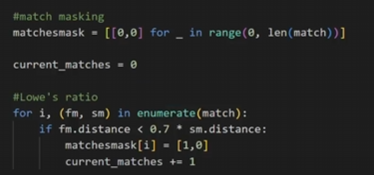
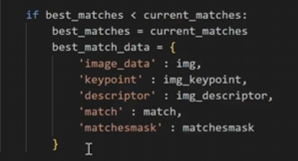
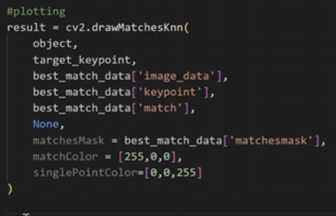

In [ ]:
#Feature Matching

#FLANN
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
# match = flann.knnMatch(target_desc,img_desc,2)

#BF
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# match = bf.match(target_desc, img_desc)
# match = sorted(match, key=lambda x: x.distance)

# Apply ratio test
# good_matches = []
# for m, n in match:
#     if m.distance < 0.7 * n.distance:
#         good_matches.append(m)
# matches = good_matches

In [45]:
# cap = cv2.VideoCapture(0)
# ret, frame = cap.read()
# cv2.imshow('Camera', frame)
# cv2.waitKey(0)
# cv2.destroyAllWindows()